# Training and Evaluating a POS Tagger

In [1]:
%load_ext autoreload
%autoreload 2

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import load_word2vec_format
from gensim.models import Word2Vec, KeyedVectors

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix

from training import POSDataset, Model, train_eval
from preprocessing import split_text_into_lines, extract_text_and_target
from analysis import get_metrics, inference_with_metrics

## Preprocessing

### Create dataframe

In [4]:
with open('train.txt') as f:
    train_data = f.readlines()
with open('test.txt') as f:
    test_data = f.readlines()

In [11]:
train_lines = split_text_into_lines(train_data)
test_lines = split_text_into_lines(test_data)

In [14]:
train_text, train_targets = extract_text_and_target(train_lines)
test_text, test_targets = extract_text_and_target(test_lines)

In [21]:
train_df = pd.DataFrame(data={"text": train_text, "target": train_targets, "stage": ["train" for x in train_text]})
test_df = pd.DataFrame(data={"text": test_text, "target": test_targets, "stage": ["test" for x in test_text]})

In [22]:
df = pd.concat([train_df, test_df], axis=0)

In [23]:
df.head()

,text,target,stage
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,...",train
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,...",train
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,...",train
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T...",train
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,...",train


In [212]:
# check if length of X and Y are the same for each sample
for idx, row in df.iterrows():
    if len(row["text"]) != len(row["target"]):
        print(idx)

## EDA

In [218]:
print(
    f"Total number of sentences:\n" 
    f"Training set {len(train_df)}\n"
    f"Test set {len(test_df)}"
)

Total number of sentences:
Training set 8044
Test set 2013


In [219]:
avg_train_sent_length = np.mean([len(row["text"]) for _, row in train_df.iterrows()])
avg_test_sent_length = np.mean([len(row["text"]) for _, row in test_df.iterrows()])
    
print(
    f"Avg. number of words per sentence:\n"
    f"Training set {avg_train_sent_length:.1f}\n"
    f"Test set {avg_test_sent_length:.1f}"
)

Avg. number of words per sentence:
Training set 23.7
Test set 23.5


In [220]:
print("Example line:\n", df["text"].iloc[1])

Example line:
 ['Rockwell', 'said', 'the', 'agreement', 'calls', 'for', 'it', 'to', 'supply', '200', 'additional', 'so-called', 'shipsets', 'for', 'the', 'planes', '.']


In [221]:
unique_pos_tags = set()
for idx, row in df.iterrows():
    for tag in row["target"]:
        if tag not in unique_pos_tags:
            unique_pos_tags.add(tag)

In [188]:
for string, df in zip(["train", "test"],[train_df, test_df]):
    
    tag_counts = dict()
    for tag in unique_pos_tags:
        tag_counts[tag] = 0
        
    for idx in range(len(df)):
        for tag in df["target"].iloc[idx]:
            tag_counts[tag] += 1
            
    classes = list(tag_counts.keys())
    counts = list(tag_counts.values())
    counts, classes = zip(*sorted(zip(counts, classes), reverse=True))
    
    #plt.bar(list(range(len(tag_counts.keys()))), list(tag_counts.values()))
    #plt.title(f"Target class distribution - {string.capitalize()}")
    #plt.show()

[0, False]
[0, False]


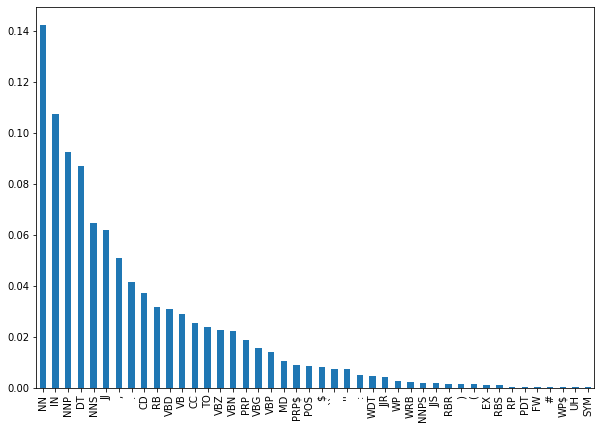

In [236]:
pos_tags = list()
for idx, row in train_df.iterrows():
    pos_tags.extend(row["target"])

plt.figure(figsize=(10,7))
pd.Series(pos_tags).value_counts(normalize=True).plot.bar()
plt.show()

### Targets

In [25]:
# create POS encodings
unique_pos_tags = set()
for idx in range(len(df)):
    for tag in df["target"].iloc[idx]:
        if tag not in unique_pos_tags:
            unique_pos_tags.add(tag)

print(unique_pos_tags)

{'CC', '.', 'VBD', 'JJS', 'VB', 'FW', ':', 'IN', 'VBG', 'WRB', 'POS', ',', 'NNS', 'RBR', 'WP', 'PDT', 'JJ', 'UH', 'NNPS', 'TO', '``', 'RBS', 'WDT', '#', '$', 'RB', 'JJR', 'NNP', 'MD', 'NN', 'VBN', 'VBP', 'PRP$', '(', "''", 'EX', 'WP$', 'CD', 'DT', 'RP', ')', 'PRP', 'VBZ', 'SYM'}


In [26]:
pos2value = dict()
pos2value[0] = 0
for idx, tag in enumerate(unique_pos_tags):
    pos2value[tag] = idx + 1  # because 0 will be padding token in both text and target

value2pos = {v: k for k, v in pos2value.items()}

print(pos2value)

{0: 0, 'CC': 1, '.': 2, 'VBD': 3, 'JJS': 4, 'VB': 5, 'FW': 6, ':': 7, 'IN': 8, 'VBG': 9, 'WRB': 10, 'POS': 11, ',': 12, 'NNS': 13, 'RBR': 14, 'WP': 15, 'PDT': 16, 'JJ': 17, 'UH': 18, 'NNPS': 19, 'TO': 20, '``': 21, 'RBS': 22, 'WDT': 23, '#': 24, '$': 25, 'RB': 26, 'JJR': 27, 'NNP': 28, 'MD': 29, 'NN': 30, 'VBN': 31, 'VBP': 32, 'PRP$': 33, '(': 34, "''": 35, 'EX': 36, 'WP$': 37, 'CD': 38, 'DT': 39, 'RP': 40, ')': 41, 'PRP': 42, 'VBZ': 43, 'SYM': 44}


In [31]:
targets_encoded = list()
for idx in range(len(df)):
    target_encoded = list()
    for tag in df["target"].iloc[idx]:
        target_encoded.append(pos2value[tag])
    targets_encoded.append(target_encoded)

In [32]:
sentence_lengths = [len(train_df["text"].iloc[idx]) for idx in range(len(train_df))]
max_seq_length = max(sentence_lengths)
print("Median sentence length", np.median(sentence_lengths))
print("Max sentence length", max_seq_length)

Median sentence length 23.0
Max sentence length 78


In [33]:
targets_padded = pad_sequences(targets_encoded, maxlen=max_seq_length, padding='post')
targets_padded = [target.tolist() for target in targets_padded]

In [34]:
print(len(targets_encoded[0]))
print(len(targets_padded[0]))

37
78


In [35]:
df["target_encoded"] = targets_encoded
df["target_padded"] = targets_padded

### Inputs

#### 1 - Tokenizing + Vocabulary Keras

In [39]:
text = list()
for idx in range(len(df)):
    text.append([word.lower() for word in df["text"].iloc[idx]])
text_combined = [word for sentence in text for word in sentence]

In [40]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(text_combined)
text_encoded = tokenizer.texts_to_sequences(text)
word2value = tokenizer.word_index
value2word = {v: k for k, v in word2value.items()}

In [41]:
# tokenizer.word_counts

In [42]:
texts_padded = pad_sequences(text_encoded, maxlen=max_seq_length, padding='post')
texts_padded = [text.tolist() for text in texts_padded]

In [43]:
df["text_encoded"] = text_encoded
df["text_padded"] = texts_padded

In [44]:
print(len(text_encoded[0]))
print(len(texts_padded[0]))

37
78


In [45]:
for idx in range(len(df)):
    if len(df["text_padded"].iloc[idx]) != len(df["target_padded"].iloc[idx]):
        print(idx)

In [48]:
df.sample(3)

,text,target,stage,target_encoded,target_padded,text_encoded,text_padded
1875,"[Fears, that, Ford, 's, ardor, might, be, cool...","[NNS, IN, NNP, POS, NN, MD, VB, NN, NN, NNP, N...",test,"[13, 8, 28, 11, 30, 29, 5, 30, 30, 28, 13, 8, ...","[13, 8, 28, 11, 30, 29, 5, 30, 30, 28, 13, 8, ...","[1437, 11, 601, 10, 19349, 300, 28, 19350, 352...","[1437, 11, 601, 10, 19349, 300, 28, 19350, 352..."
2748,"[Fear, is, the, father, of, panic, .]","[NN, VBZ, DT, NN, IN, NN, .]",train,"[30, 43, 39, 30, 8, 30, 2]","[30, 43, 39, 30, 8, 30, 2, 0, 0, 0, 0, 0, 0, 0...","[1066, 15, 2, 2161, 4, 3140, 3]","[1066, 15, 2, 2161, 4, 3140, 3, 0, 0, 0, 0, 0,..."
3536,"[Rick, Sherlund, ,, a, Goldman, Sachs, analyst...","[NNP, NNP, ,, DT, NNP, NNP, NN, ,, VBZ, VBN, P...",train,"[28, 28, 12, 39, 28, 28, 30, 12, 43, 31, 33, 1...","[28, 28, 12, 39, 28, 28, 30, 12, 43, 31, 33, 1...","[8590, 6616, 1, 6, 2073, 2357, 366, 1, 35, 116...","[8590, 6616, 1, 6, 2073, 2357, 366, 1, 35, 116..."


#### 2 - Tokenizing + Vocabulary Custom

In [214]:
df["text_lower"] = text

In [195]:
# create vocabulary based on unique words and IDs

unique_words = set()
for idx in range(len(df)):
    for word in df["text"].iloc[idx]:
        if word.lower() not in unique_words:
            unique_words.add(word.lower())

print(len(unique_tokens))

word2value = dict()
for idx, word in enumerate(unique_words):
    word2value[word] = idx

17258


In [164]:
texts_encoded = list()
for idx in range(len(df)):
    text_encoded = list()
    for word in df["text"].iloc[idx]:
        text_encoded.append(word2value[word.lower()])
    texts_encoded.append(text_encoded)

In [165]:
df["text_encoded"] = texts_encoded

#### Word Embeddings

##### 1 - downloaded word2vec

In [49]:
word2vec = load_word2vec_format("/home/hkortschak/Repositories/commonlit_kaggle/xund/GoogleNews-vectors-negative300.bin", binary=True)

In [50]:
embedding_size = 300
vocabulary_size = len(word2value) + 1
embedding_weights = np.zeros((vocabulary_size, embedding_size))
count = 0
for word, idx in word2value.items():
    try: 
        embedding_weights[idx] = word2vec[word]
    except KeyError:
        count += 1
        # print(word, tokenizer.word_counts[word])
print(count)

5713


In [51]:
embedding_weights = torch.tensor(embedding_weights)

##### 2 - gensim word2vec

In [220]:
word2vec_model = Word2Vec(sentences=df["text_lower"], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv
# word_vectors.save("word2vec.wordvectors")

In [233]:
vector = word2vec_model.wv['man']  # get numpy vector of a word
sims = word2vec_model.wv.most_similar('man', topn=10)  # get other similar words
print(sims)

[('peters', 0.9969028830528259), ('she', 0.9968954920768738), ('suit', 0.9968575835227966), ('himself', 0.9968065023422241), ('bush', 0.9967989921569824), ('decision', 0.9967637658119202), ('saw', 0.9967111349105835), ('great', 0.9965247511863708), ('deloitte', 0.9962803721427917), ('whole', 0.9959662556648254)]


In [236]:
word_vectors = KeyedVectors.load("word2vec.wordvectors", mmap='r')

### Split dataset

In [52]:
len(df)

10950

In [53]:
train_df = df[df["stage"] == "train"]
test_df = df[df["stage"] == "test"]

train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)
num_train_samples = int(len(train_df) * 0.9) + 1
num_valid_samples = int(len(train_df) * 0.1)
print(num_train_samples, num_valid_samples)

8044 893


In [54]:
train_df = df[:num_train_samples].reset_index()
valid_df = df[num_train_samples:].reset_index()

In [146]:
train_X = train_df["text_padded"]
train_Y = train_df["target_padded"]

valid_X = valid_df["text_padded"]
valid_Y = valid_df["target_padded"]

test_X = test_df["text_padded"]
test_Y = test_df["target_padded"]

### Data Loader

In [147]:
train_ds = POSDataset(train_X, train_Y) 
valid_ds = POSDataset(valid_X, valid_Y) 
test_ds = POSDataset(test_X, test_Y) 

In [148]:
train_dl = DataLoader(train_ds, batch_size=24)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

## Model

#### Try out model

In [558]:
print(train_df["text"].iloc[1])
input_ = train_df["text_padded"].iloc[1] # (max_seq_length)
input_ = torch.tensor(input_, dtype=torch.long).unsqueeze(0)
print(input_.shape)
print(input_.dtype)

['The', 'promotions', '--', 'dubbed', 'everything', 'from', "'T-", 'is', 'the', 'Season', 'to', 'be', 'Jolly', 'to', 'Kringle', 'fares', '--', 'put', 'round-trip', 'fares', 'at', '$', '98', ',', '$', '148', 'and', '$', '198', '.']
torch.Size([1, 78])
torch.int64


In [483]:
output = model(input_)

Input torch.Size([1, 78])
Embedding torch.Size([1, 78, 300])
RNN Output torch.Size([1, 78, 64])
TDD Input torch.Size([1, 1, 78, 64])
TDD Output torch.Size([1, 45, 78, 1])
Return torch.Size([1, 45, 78])


In [484]:
cls_output = torch.argmax(output, dim=1).squeeze(0)
print(cls_output.shape)

torch.Size([78])


In [489]:
print(train_df["target_padded"].iloc[1])
print(cls_output)

[28, 29, 20, 28, 17, 17, 40, 43, 29, 7, 11, 40, 35, 41, 3, 41, 3, 43, 20, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([42, 42, 37, 15, 15,  7, 15, 29, 37, 40, 42, 15, 17, 15, 40, 38, 40, 37,
        15, 15, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37])


In [515]:
classes = list(value2pos.keys())

target = np.array(train_df["target_encoded"].iloc[1])
pred = np.array(cls_output[:len(target)])

print(target)
print(pred)

f1 = f1_score(target, pred, labels=classes, average="micro")
print(f1)
#for cls in classes[1:]: # don't take adding class into account
#    target_cls = np.where(target == cls, target, 0)
#    pred_cls = np.where(pred == cls, pred, 0)
#    #print(target_cls)
#    #print(pred_cls)
#    f1 = f1_score(target_cls, pred_cls)
#    print(f1)
##f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', 

[28 29 20 28 17 17 40 43 29  7 11 40 35 41  3 41  3 43 20 23]
[42 42 37 15 15  7 15 29 37 40 42 15 17 15 40 38 40 37 15 15]
0.0


## Training Loop

In [61]:
class Model(nn.Module):
    def __init__(
            self,
            output_size,
            hidden_dim,
            n_layers,
            embedding_weights,
            embedding_size
    ):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights)
        self.rnn = nn.RNN(embedding_size, hidden_dim, n_layers)
        self.tdd = nn.Conv2d(1, output_size, (1, hidden_dim))

    def forward(self, x):  # (BS, SL)

        # print("Input", x.shape)  # (bs, sl)
        embedding = self.embedding(x)  # (bs, sl) --> (bs, sl, es)
        # print("Embedding", embedding.shape)
        output, hidden = self.rnn(embedding)  # (bs, sl, es) --> (bs, sl, hd)
        # print("RNN Output", output.shape)
        output = output.unsqueeze(1)  # (bs, sl, hd) --> (bs, 1, sl, hd) (add channel dim)
        # print("TDD Input", output.shape)
        output = self.tdd(output)  # (bs, 1, sl, hd) (bs, ch, w, h) --> (bs, os, sl, 1) (bs, ch, w, h)
        # print("TDD Output", output.shape)
        output = output.squeeze(-1)  # (bs, os, sl) --> postprecessing: argmax(dim=1) --> (bs, sl)
        # print("Return", output.shape)

        return output

In [149]:
model = Model(
    output_size=len(pos2value), 
    hidden_dim=64, 
    n_layers=1, 
    embedding_weights=embedding_weights, 
    embedding_size=300
).double()

In [151]:
train_losses, valid_losses = train_eval(
    train_dataloader=train_dl, 
    valid_dataloader=valid_dl, 
    model=model,
    num_epochs=1000,
    early_stopping=15,
    learning_rate=0.0001,
    weight_decay=1e-8,
    device=torch.device("cpu")
)

test
----- Epoch 1 ----- 
Avg. train loss 2.457
Avg. valid loss 3.065
----- Epoch 2 ----- 
Avg. train loss 1.603
Avg. valid loss 3.074
----- Epoch 3 ----- 
Avg. train loss 1.394
Avg. valid loss 2.785
----- Epoch 4 ----- 
Avg. train loss 1.138
Avg. valid loss 2.535
----- Epoch 5 ----- 
Avg. train loss 1.015
Avg. valid loss 2.252
----- Epoch 6 ----- 
Avg. train loss 0.905
Avg. valid loss 1.987
----- Epoch 7 ----- 
Avg. train loss 0.806
Avg. valid loss 1.697
----- Epoch 8 ----- 
Avg. train loss 0.747
Avg. valid loss 1.520
----- Epoch 9 ----- 
Avg. train loss 0.690
Avg. valid loss 1.302
----- Epoch 10 ----- 
Avg. train loss 0.633
Avg. valid loss 1.091
----- Epoch 11 ----- 
Avg. train loss 0.590
Avg. valid loss 0.930
----- Epoch 12 ----- 
Avg. train loss 0.573
Avg. valid loss 0.888
----- Epoch 13 ----- 
Avg. train loss 0.559
Avg. valid loss 0.749
----- Epoch 14 ----- 
Avg. train loss 0.555
Avg. valid loss 0.748
----- Epoch 15 ----- 
Avg. train loss 0.538
Avg. valid loss 0.671
----- Epoch 16

## Analysis

In [202]:
classes = list(value2pos.keys())
print(classes)
print(len(classes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
45


In [203]:
correct_valid, total_valid = inference_with_metrics(model, valid_dl, classes)

In [204]:
correct_test, total_test = inference_with_metrics(model, test_dl, classes)

In [206]:
print(
    f"Valid Top-1 Accuracy: {correct_valid['all']/total_valid['all']:.4f}\n"
    f"Test Top-1 Accuracy: {correct_test['all']/total_test['all']:.4f}"
)

Valid Top-1 Accuracy: 0.6326
Test Top-1 Accuracy: 0.6344


In [211]:
for cls, tag in value2pos.items():
    if cls != 0:
        print(f"{tag:6} {correct_test[cls]/(total_test[cls]+1e-10):.4f}")

CC     0.2825
.      0.0000
VBD    0.8940
JJS    0.8961
VB     0.8440
FW     0.2500
:      0.0000
IN     0.7740
VBG    0.9011
WRB    0.9892
POS    0.0000
,      0.0000
NNS    0.9562
RBR    0.4225
WP     1.0000
PDT    0.0000
JJ     0.7203
UH     0.0000
NNPS   0.1692
TO     0.0000
``     0.0000
RBS    0.9796
WDT    0.5297
#      0.0000
$      0.9922
RB     0.9136
JJR    0.9653
NNP    0.4438
MD     1.0000
NN     0.8854
VBN    0.7138
VBP    0.3896
PRP$   1.0000
(      0.0000
''     0.0000
EX     1.0000
WP$    1.0000
CD     0.3405
DT     0.7443
RP     0.0000
)      0.0000
PRP    0.9988
VBZ    0.8970
SYM    0.0000


In [155]:
for string, cm in zip(["valid", "test"], [valid_confusion_matrix, test_confusion_matrix]):
    
    precision, recall, f1 = get_metrics(
        cm["total"]["fp"],
        cm["total"]["fn"],
        cm["total"]["tp"],
    )
    
    print(f"\nGLOBAL METRICS {string.upper()}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")


GLOBAL METRICS VALID
Precision: 0.8863
Recall: 0.0000
F1: 0.0000

GLOBAL METRICS TEST
Precision: 0.8865
Recall: 0.0000
F1: 0.0000


In [174]:
for string, cm in zip(["valid", "test"], [valid_confusion_matrix, test_confusion_matrix]):
    total = cm["total"]["tn"] + cm["total"]["fp"] + cm["total"]["fn"] + cm["total"]["tp"]
    cm_arr = np.array(
        [
            [
                cm["total"]["tn"], 
                cm["total"]["fp"]
            ], 
            [
                cm["total"]["fn"], 
                cm["total"]["tp"]
            ]
        ]
    )
    print(f"\nConfusion Matrix {string.capitalize()}")
    print(pd.DataFrame(cm_arr))
#conf_matrix = pd.DataFrame(np.array([[total_tn, total_fp], [total_fn, total_tp]]))
#print conf_matrix


Confusion Matrix Valid
         0      1
0  9899502   5545
1    25113  43232

Confusion Matrix Test
         0      1
0  6857389   3850
1    17321  30056


In [103]:
conf_matrix_df = pd.DataFrame(conf_matrix.astype("uint8"))

In [104]:
pd.set_option('display.max_columns', None)
conf_matrix_df
conf_matrix_df.style.background_gradient(cmap="Blues")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,0,2,0,0,0,0,0,0,0,4,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,17,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
